# **NeuroScience Final Project**

## ***Tina Halimi - 400101078***

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 304, in register_gymnasium_envs
    _register_atari_envs()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 205, in _register_atari_envs
    import ale_py
  File "/usr/local/lib/python3.11/dist-packages/ale_py/__init__.py", line 68, in <module>
    register_v0_v4_envs()
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 179, in register_v0_v4_envs
    _register_rom_configs(legacy_games, obs_types, versions)
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 64, in _register_rom_configs
    gymnasium.register(
    ^^^^^^^^^^^

▶ Saved truncation video: first_truncation.mp4
▶ Saved truncation video: deterministic_training.mp4
✅ Saved greedy run video: deterministic_greedy.mp4 (frames: 7, fps: 8)
▶ Saved truncation video: stochastic_training.mp4
✅ Saved greedy run video: stochastic_greedy.mp4 (frames: 23, fps: 8)


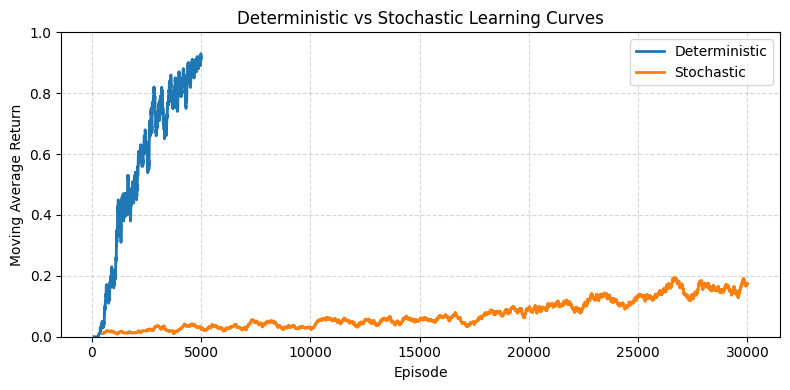


Mode Comparison
      Variant  Success Rate  Avg Steps  Episodes Used
Deterministic         1.000      6.000           5000
   Stochastic         0.754     44.281          30000
✅ Saved greedy run video: reward_shaping_base_greedy.mp4 (frames: 7, fps: 8)
✅ Saved greedy run video: reward_shaping_step-0.005_greedy.mp4 (frames: 7, fps: 8)
✅ Saved greedy run video: reward_shaping_hole-1.0_greedy.mp4 (frames: 7, fps: 8)
✅ Saved greedy run video: reward_shaping_goal+5.0_greedy.mp4 (frames: 7, fps: 8)
▶ Saved truncation video: reward_shaping_combo_training.mp4
✅ Saved greedy run video: reward_shaping_combo_greedy.mp4 (frames: 7, fps: 8)


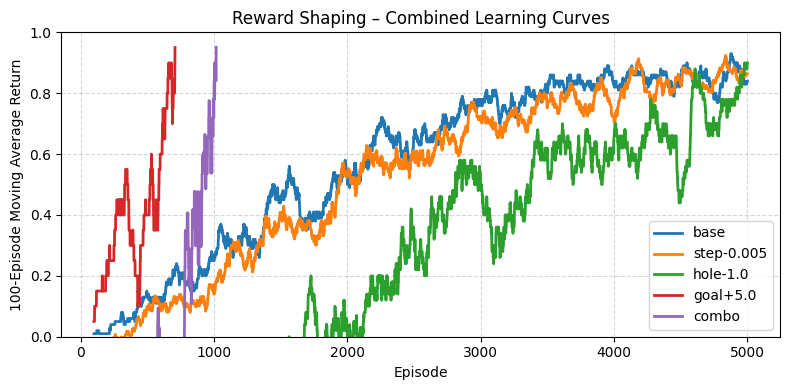


Reward-Shaping Comparison (including train times)
   Variant  Success Rate  Avg Steps  Episodes Used  Train Time (s)
      base           1.0        6.0           5000            1.06
step-0.005           1.0        6.0           5000            1.05
  hole-1.0           1.0        6.0           5000            1.02
  goal+5.0           1.0        6.0            708            0.16
     combo           1.0        6.0           1017           15.13


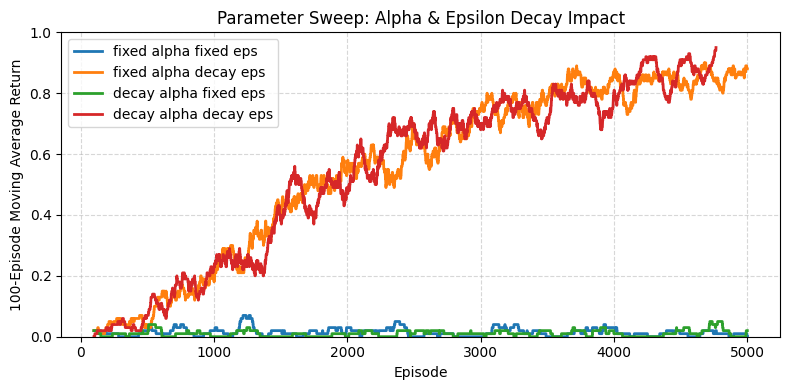


Parameter Sweep Comparison
              Variant  Success Rate  Avg Steps  Episodes Used
fixed_alpha_fixed_eps           1.0        6.0           5000
fixed_alpha_decay_eps           1.0        6.0           5000
decay_alpha_fixed_eps           1.0        6.0           5000
decay_alpha_decay_eps           1.0        6.0           4765

✅ All MP4s, plots, and summary tables generated systematically and ready for report and presentation.


In [1]:
import os
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import imageio
import collections
import pandas as pd
import time

# ─── Configuration ───────────────────────────────
SEED = 2025
np.random.seed(SEED)

NUM_EPISODES      = 5000
STEP_LIMIT        = 20
ALPHA             = 0.8
GAMMA             = 0.95
EPS_START         = 1.0
EPS_END           = 0.1
EVAL_EPISODES     = 3000
MOV_AVG_WINDOW    = 100
EARLY_STOP_THRESH = 0.95
MAX_VIDEO_STEPS   = 200

VIDEO_DIR = "lake_videos"
os.makedirs(VIDEO_DIR, exist_ok=True)

# ─── Core Functions ──────────────────────────────
def make_frozen_lake(slippery: bool, render_mode=None):
    env = gym.make(
        "FrozenLake-v1",
        map_name="4x4",
        is_slippery=slippery,
        render_mode=render_mode
    )
    env.reset(seed=SEED)
    return env


def init_q_table(env):
    return np.zeros((env.observation_space.n, env.action_space.n))


def pick_action(state, q_table, epsilon, action_space):
    if np.random.rand() < epsilon:
        return action_space.sample()
    return int(np.argmax(q_table[state]))


def train_agent(env, num_episodes, alpha, gamma, eps_start, eps_end,
                step_cap, early_stop=0.95, record_video=False, video_name=None):
    q = init_q_table(env)
    eps = eps_start
    eps_decay = (eps_end/eps_start)**(1/num_episodes)
    returns = []
    got_video = False

    writer = None
    if record_video and video_name:
        writer = imageio.get_writer(
            os.path.join(VIDEO_DIR, video_name),
            format="ffmpeg", codec="libx264", fps=4, quality=8
        )

    for ep in range(1, num_episodes+1):
        state, _ = env.reset()
        total_reward = 0
        steps = 0

        if writer:
            writer.append_data(env.render())

        while True:
            action = pick_action(state, q, eps, env.action_space)
            nxt, reward, done, _, _ = env.step(action)
            steps += 1
            # Truncation
            if steps >= step_cap and not done:
                done, reward = True, 0

            q[state, action] += alpha * (
                reward + gamma * np.max(q[nxt]) - q[state, action]
            )
            state = nxt
            total_reward += reward

            if writer:
                writer.append_data(env.render())

            if done:
                if writer and steps > 0 and not got_video:
                    got_video = True
                    print(f"▶ Saved truncation video: {video_name}")
                break

        returns.append(total_reward)
        eps *= eps_decay

        if ep >= MOV_AVG_WINDOW:
            ma = np.mean(returns[-MOV_AVG_WINDOW:])
            if ma >= early_stop:
                break

    if writer:
        writer.close()

    return q, returns


def evaluate_agent(q_table, env, trials, step_cap):
    wins, tot_steps = 0, 0
    for _ in range(trials):
        state, _ = env.reset()
        done, steps = False, 0
        while not done:
            action = int(np.argmax(q_table[state]))
            state, reward, done, _, _ = env.step(action)
            steps += 1
            if steps >= step_cap and not done:
                done, reward = True, 0
            if done and reward > 0:
                wins += 1
        tot_steps += steps
    return wins/trials, tot_steps/trials


def record_greedy_run(q_table, env, filename,
                      step_cap=STEP_LIMIT, max_video_steps=MAX_VIDEO_STEPS, fps=8):
    frames = []
    state, _ = env.reset()
    done, steps = False, 0
    frames.append(env.render())

    while not done and steps < max_video_steps:
        action = int(np.argmax(q_table[state]))
        state, reward, done, _, _ = env.step(action)
        frames.append(env.render())
        steps += 1

    path = os.path.join(VIDEO_DIR, filename)
    with imageio.get_writer(path, fps=fps, codec='libx264') as writer:
        for frame in frames:
            writer.append_data(frame)
    print(f"✅ Saved greedy run video: {filename} (frames: {len(frames)}, fps: {fps})")


def bar_summary(variants, stats, ylabel):
    rows = [{
        'Variant': v,
        'Success Rate': stats[v][0],
        'Avg Steps': stats[v][1],
        'Episodes Used': stats[v][2]
    } for v in variants]
    df = pd.DataFrame(rows)
    print(f"\n{ylabel}")
    print(df.to_string(index=False))


# ─── Reward Shaping ─────────────────────────────
class ShapedRewardWrapper(gym.Wrapper):
    def __init__(self, env, move_cost=0.0, hole_cost=0.0, goal_bonus=1.0):
        super().__init__(env)
        self.move_cost = move_cost
        self.hole_cost = hole_cost
        self.goal_bonus = goal_bonus

    def step(self, action):
        obs, reward, done, trunc, info = self.env.step(action)
        if done and reward > 0:
            reward = self.goal_bonus
        elif done:
            reward = self.hole_cost
        else:
            reward = self.move_cost
        return obs, reward, done, trunc, info


# ─── Reward Shaping Experiment ──────────────────
def reward_shaping_experiments():
    configs = collections.OrderedDict([
        ("base",      {"move_cost": 0.0,    "hole_cost": 0.0,   "goal_bonus": 1.0}),
        ("step-0.005",{"move_cost": -0.005, "hole_cost": 0.0,   "goal_bonus": 1.0}),
        ("hole-1.0",  {"move_cost": 0.0,    "hole_cost": -1.0,  "goal_bonus": 1.0}),
        ("goal+5.0",  {"move_cost": 0.0,    "hole_cost": 0.0,   "goal_bonus": 5.0}),
        ("combo",     {"move_cost": -0.005, "hole_cost": -1.0,  "goal_bonus": 5.0}),
    ])

    summary, curves, times = {}, {}, {}
    for name, params in configs.items():
        record_training = (name == "combo")
        env = make_frozen_lake(slippery=False,
                               render_mode="rgb_array" if record_training else None)
        wrapped = ShapedRewardWrapper(env, **params)

        start_time = time.time()
        qtab, ret_hist = train_agent(
            wrapped,
            NUM_EPISODES,
            ALPHA,
            GAMMA,
            EPS_START,
            EPS_END,
            STEP_LIMIT,
            EARLY_STOP_THRESH,
            record_video=record_training,
            video_name=f"reward_shaping_{name}_training.mp4" if record_training else None
        )
        times[name] = time.time() - start_time

        succ, avg_s = evaluate_agent(qtab, wrapped, EVAL_EPISODES, STEP_LIMIT)
        summary[name] = (succ, avg_s, len(ret_hist))
        curves[name] = ret_hist

        env_vis = make_frozen_lake(slippery=False, render_mode="rgb_array")
        wrapped_vis = ShapedRewardWrapper(env_vis, **params)
        record_greedy_run(qtab, wrapped_vis,
                          f"reward_shaping_{name}_greedy.mp4")

    # Plot combined learning curves
    fig, ax = plt.subplots(figsize=(8, 4))
    for name, hist in curves.items():
        mov_avg = np.convolve(hist,
                              np.ones(MOV_AVG_WINDOW)/MOV_AVG_WINDOW,
                              mode="valid")
        ax.plot(range(MOV_AVG_WINDOW-1,
                      MOV_AVG_WINDOW-1+len(mov_avg)),
                mov_avg, lw=2, label=name)
    ax.set_title("Reward Shaping – Combined Learning Curves")
    ax.set_xlabel("Episode")
    ax.set_ylabel(f"{MOV_AVG_WINDOW}-Episode Moving Average Return")
    ax.set_ylim(0, 1)
    ax.grid(True, ls='--', alpha=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Summary table with time comparison
    rows = []
    for v in configs.keys():
        succ, avg_s, eps_used = summary[v]
        rows.append({
            'Variant': v,
            'Success Rate': succ,
            'Avg Steps': avg_s,
            'Episodes Used': eps_used,
            'Train Time (s)': round(times[v], 2)
        })
    df = pd.DataFrame(rows)
    print("\nReward-Shaping Comparison (including train times)")
    print(df.to_string(index=False))

# ─── Deterministic vs Stochastic ────────────────
def compare_deterministic_and_stochastic(record_videos=False):
    tasks = [
        ("Deterministic", False, STEP_LIMIT, NUM_EPISODES, GAMMA, EARLY_STOP_THRESH, MOV_AVG_WINDOW),
        ("Stochastic",    True,  100,         30000,   0.97, 0.90,             500),
    ]
    summary, curves = {}, {}

    for name, slip, step_cap, episodes, gamma, stop, mov_win in tasks:
        env = make_frozen_lake(slip,
                               render_mode="rgb_array" if record_videos else None)
        qtab, hist = train_agent(
            env,
            episodes,
            ALPHA,
            gamma,
            EPS_START,
            EPS_END,
            step_cap,
            early_stop=stop,
            record_video=record_videos,
            video_name=f"{name.lower()}_training.mp4" if record_videos else None
        )
        succ, avg_s = evaluate_agent(qtab, env, EVAL_EPISODES, step_cap)
        summary[name] = (succ, avg_s, len(hist))
        curves[name] = (hist, mov_win)

        env_vis = make_frozen_lake(slip, render_mode="rgb_array")
        record_greedy_run(qtab, env_vis, f"{name.lower()}_greedy.mp4")

    fig, ax = plt.subplots(figsize=(8, 4))
    for name, (hist, mov_win) in curves.items():
        mov_avg = np.convolve(hist,
                              np.ones(mov_win)/mov_win,
                              mode="valid")
        ax.plot(range(mov_win-1,
                      mov_win-1+len(mov_avg)),
                mov_avg, lw=2, label=name)
    ax.set_title("Deterministic vs Stochastic Learning Curves")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Moving Average Return")
    ax.set_ylim(0, 1)
    ax.grid(True, ls='--', alpha=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()

    bar_summary(list(summary.keys()), summary, "Mode Comparison")

# ─── Parameter Sweep ────────────────────────────
def parameter_sweep_analysis():
    """Parameter Sweep: Compare fixed vs decaying alpha/epsilon on deterministic Frozen Lake."""
    sweep_configs = collections.OrderedDict([
        ("fixed_alpha_fixed_eps", {"alpha_decay": False, "eps_decay": False}),
        ("fixed_alpha_decay_eps", {"alpha_decay": False, "eps_decay": True}),
        ("decay_alpha_fixed_eps", {"alpha_decay": True,  "eps_decay": False}),
        ("decay_alpha_decay_eps", {"alpha_decay": True,  "eps_decay": True}),
    ])

    summary, curves = {}, {}

    for name, flags in sweep_configs.items():
        env = make_frozen_lake(slippery=False)
        q = init_q_table(env)
        eps = EPS_START
        eps_decay_rate = (
            (EPS_END/EPS_START)**(1/NUM_EPISODES)
            if flags["eps_decay"] else 1.0
        )
        alpha = ALPHA
        alpha_decay_rate = (
            (0.1/ALPHA)**(1/NUM_EPISODES)
            if flags["alpha_decay"] else 1.0
        )

        returns = []
        for ep in range(1, NUM_EPISODES+1):
            state, _ = env.reset()
            total_reward, steps = 0, 0
            while True:
                action = pick_action(state, q, eps, env.action_space)
                nxt, reward, done, _, _ = env.step(action)
                steps += 1
                if steps >= STEP_LIMIT and not done:
                    done, reward = True, 0
                q[state, action] += alpha * (
                    reward + GAMMA * np.max(q[nxt]) - q[state, action]
                )
                state = nxt
                total_reward += reward
                if done:
                    break
            returns.append(total_reward)
            eps   *= eps_decay_rate
            alpha *= alpha_decay_rate
            if ep >= MOV_AVG_WINDOW and np.mean(returns[-MOV_AVG_WINDOW:]) >= EARLY_STOP_THRESH:
                break

        succ, avg_s = evaluate_agent(q, env, EVAL_EPISODES, STEP_LIMIT)
        summary[name] = (succ, avg_s, len(returns))
        curves[name] = returns

    fig, ax = plt.subplots(figsize=(8, 4))
    for name, hist in curves.items():
        mov_avg = np.convolve(hist,
                              np.ones(MOV_AVG_WINDOW)/MOV_AVG_WINDOW,
                              mode="valid")
        ax.plot(range(MOV_AVG_WINDOW-1,
                      MOV_AVG_WINDOW-1+len(mov_avg)),
                mov_avg, lw=2, label=name.replace("_", " "))
    ax.set_title("Parameter Sweep: Alpha & Epsilon Decay Impact")
    ax.set_xlabel("Episode")
    ax.set_ylabel(f"{MOV_AVG_WINDOW}-Episode Moving Average Return")
    ax.set_ylim(0, 1)
    ax.grid(True, ls='--', alpha=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()

    bar_summary(list(summary.keys()), summary, "Parameter Sweep Comparison")


# ─── Main Workflow ───────────────────────────────
if __name__ == "__main__":
    # Truncation demo video
    trunc_env = make_frozen_lake(slippery=False, render_mode="rgb_array")
    q_trunc, _ = train_agent(
        trunc_env,
        NUM_EPISODES,
        ALPHA,
        GAMMA,
        EPS_START,
        EPS_END,
        STEP_LIMIT,
        early_stop=EARLY_STOP_THRESH,
        record_video=True,
        video_name="first_truncation.mp4"
    )

    # Deterministic & Stochastic training videos + greedy runs
    compare_deterministic_and_stochastic(record_videos=True)

    # Reward shaping experiments: includes training video for 'combo' variant + time comparison + all greedy runs
    reward_shaping_experiments()

    # Parameter sweep analysis
    parameter_sweep_analysis()

    print("\n✅ All MP4s, plots, and summary tables generated systematically and ready for report and presentation.")
